# create a model
* create a pretrained model
* train the model with new data
* save the trained model

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

print(f"torch {torch.__version__}, torchvision {torchvision.__version__}")

torch 2.0.1+cu118, torchvision 0.15.2+cu118


In [2]:
# import torchinfo
try:
    from torchinfo import summary
except:
    print(f"[INFO] installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

In [3]:
# import modules from sources
from sources import utils, datasetup, engine, models

2023-11-09 14:42:27.503989: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 14:42:27.546982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 14:42:28.275149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# download data
source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"

image_path_20 = datasetup.download_data(
    source=source,
    destination="image_20"
)

[INFO] data/image_20 exist.


In [6]:
# setup train and test directory
train_dir = image_path_20 / "train"
test_dir = image_path_20 / "test"

In [7]:
# get a pretrained efficientnetb2 model
model, model_transforms = models.create_effnet(effnet_version=2)

[INFO] creating EfficientNet_B2...


In [8]:
# create dataloaders
train_dataloader, test_dataloader, class_names = datasetup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=model_transforms,
    test_transforms=model_transforms,
    batch_size=32
)

[INFO] creating dataloaders... 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f462c69dd50> 
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f462c69c150> 
number of class_names: 3


In [9]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
# do training
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 | train_loss: 0.9735 | train_acc: 0.5292 | test_loss: 0.7379 | test_acc: 0.9193
epoch: 1 | train_loss: 0.6801 | train_acc: 0.8438 | test_loss: 0.5966 | test_acc: 0.9347
epoch: 2 | train_loss: 0.6071 | train_acc: 0.8167 | test_loss: 0.5080 | test_acc: 0.9222
epoch: 3 | train_loss: 0.4558 | train_acc: 0.9062 | test_loss: 0.4354 | test_acc: 0.9625
epoch: 4 | train_loss: 0.4261 | train_acc: 0.8688 | test_loss: 0.4015 | test_acc: 0.9375
epoch: 5 | train_loss: 0.4102 | train_acc: 0.8979 | test_loss: 0.3693 | test_acc: 0.9318
epoch: 6 | train_loss: 0.3985 | train_acc: 0.8833 | test_loss: 0.3452 | test_acc: 0.9381
epoch: 7 | train_loss: 0.3216 | train_acc: 0.9271 | test_loss: 0.3056 | test_acc: 0.9597
epoch: 8 | train_loss: 0.3659 | train_acc: 0.8896 | test_loss: 0.2916 | test_acc: 0.9563
epoch: 9 | train_loss: 0.2827 | train_acc: 0.9313 | test_loss: 0.2836 | test_acc: 0.9409
epoch: 10 | train_loss: 0.2989 | train_acc: 0.9167 | test_loss: 0.2622 | test_acc: 0.9625
epoch: 11 | train_lo

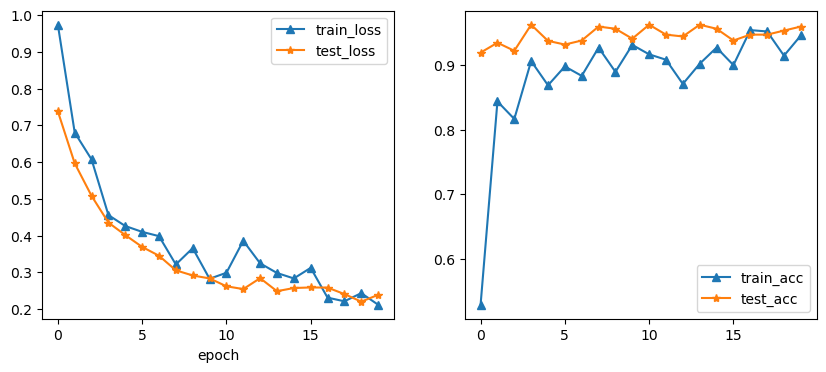

In [11]:
# visualize train and test loss and accuracy
utils.plot_loss_acc(results=results)

In [12]:
# save trained model
saved_model_path = utils.save_model(
    model=model,
    model_dir="models",
    model_name_grid=[model.name]
)

[INFO] models exists.


In [13]:
# model statistic
from pathlib import Path

# size
model_size = Path(saved_model_path).stat().st_size // (1024*1024)

# number of parameters
num_model_params = sum(torch.numel(para) for para in model.parameters())

model_results = {
    "test_loss": results["test_loss"][-1],
    "test_acc": results["test_acc"][-1],
    "model_size (MB)": model_size,
    "num_params": num_model_params
}

model_results

{'test_loss': 0.23886237740516664,
 'test_acc': 0.959659090909091,
 'model_size (MB)': 29,
 'num_params': 7705221}

# launch a local gradio
* import gradio
* create effnetb2
* load stat dict from file
* send the trained model to cpu
* create a predict function returning a tuple of:
  * a dictionary of prediction probability
  * prediction wall time
* create gradio interface
* launch local gradio

In [14]:
# import gradio
try:
    import gradio as gr
except:
    !pip install -q gradio
    import gradio as gr

In [15]:
# create a pretrained EfficientNetB2
model, model_transforms = models.create_effnet(effnet_version=2)

# send model to CPU when using free gradio
model.to("cpu")
next(iter(model.parameters())).device

[INFO] creating EfficientNet_B2...


device(type='cpu')

In [16]:
# load stat dict from file
model.load_state_dict(torch.load(
    f=saved_model_path,
    map_location=torch.device("cpu")
))

<All keys matched successfully>

In [17]:
# create predict function
from typing import Dict, Tuple
from timeit import default_timer as timer

def predict(img)->Tuple[Dict,float]:
    """predict the food name probability from a list of class names
    Args:
        img: PIL image
    Return:
        Tuple[Dict, float]
            Dict: dictionary of food name probability
            float: wall time of the food name prediction
    """

    # start the timer
    start_time = timer()
    
    # transform PIL image to torch tensor, add batch dimension
    img = model_transforms(img).unsqueeze(dim=0)

    # switch model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # food name probability prediction
        pred_probs = torch.softmax(model(img), dim=1)

    # assign prediction probability to a result dictionary
    pred_probs_dict = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }

    # prediction wall time
    pred_wtime = timer() - start_time

    # return probability dictionary and wall time
    return pred_probs_dict, pred_wtime

# test the predict function
import random
from PIL import Image

random_path = random.choice(list(image_path_20.glob("*/*/*")))
img = Image.open(random_path)
predict(img)

({'pizza': 0.012035049498081207,
  'steak': 0.0954657718539238,
  'sushi': 0.8924992084503174},
 0.07334432296920568)

In [18]:
# create a list of examples
example_list = random.sample(list(image_path_20.glob("*/*/*")),3)

In [ ]:
demo = gr.Interface(
    fn = predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="prediction time (s)")
    ],
    title="foodvisionmini",
    description="transfer learning using pretrained EfficientNetB2",
    examples=example_list
)

demo.launch(
    debug=True,
    share=True
)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://5302aefa9938d9bb2d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
